# Stimulus-Evoked Activity under *in vivo*-like conditions

In [1]:
import numpy as np
from scipy.stats import sem

from cell_template import BRANCH_COLORS
from parallel import Parallel

import sys
sys.path.append('../..')
import plot_tools as pt
import matplotlib.pylab as plt

--No graphics will be displayed.


# Protocol Description

- synapses splitted in excitatory (80%) and inhibitory (20%) categories
- background excitatory+inhibitory synaptic events at a given frequency (events through Poisson process)
- stimulus events: a set of synaptic events randomly picked within the excitatory population
- stimulus stength variable: **$n_{syn}$** the number of randomly picked synapses
- stimulus temporal width: **$\sigma$** the width of the gaussian distribution from which synaptic events are drawn
- simulations on a per branch basis -- considering only the synapses of a given branch -- performing simulations on each branch
- firing response in Hz measured in [0,100]ms window following the stimulus

## Single Simulation Example

In [151]:
def plot(filename, title='', color='tab:purple'):
    results = np.load(filename, allow_pickle=True).item()
    
    t = np.arange(len(results['Vm_soma']))*results['dt']
    fig, AX = pt.figure(axes_extents=[[(1,3)],[(1,1)]],
                        figsize=(3,0.7), left=0, bottom=0., hspace=0.)
    for r in range(int(results['nStimRepeat'])):
        tstart = results['t0']+r*results['ISI']
        pt.arrow(AX[0], [tstart, 0, 0, -10],
                 head_width=4, head_length=5, width=0.1)
        pt.annotate(AX[0], 'repeat #%i' % (r+1), (tstart, 5), 
                    rotation=90, xycoords='data', fontsize=6, ha='right')
    AX[0].plot(t, results['Vm_dend'], 'k:', lw=0.5, label=' distal\ndendrite')
    AX[0].plot(t, results['Vm_soma'], color=color, label='soma')
    AX[0].plot(t, -60+0*t, 'k:')
    pt.annotate(AX[0], '-60mV ', (0,-60), xycoords='data', ha='right', va='center')
    pt.draw_bar_scales(AX[0], Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
    AX[0].legend(frameon=False, loc=(1, 0.3))
    for i, events in enumerate(results['presynaptic_exc_events']):
        AX[1].plot(events, i*np.ones(len(events)), '.', color='g', ms=1)
    for i, events in enumerate(results['presynaptic_inh_events']):
        AX[1].plot(events, len(results['presynaptic_exc_events'])+i*np.ones(len(events)), '.', 
                   color='r', ms=1)
    pt.annotate(AX[1], 'Inh.', (0,1), ha='right', va='top', color='r')
    pt.annotate(AX[1], 'Exc.', (0,0), ha='right', va='bottom', color='g')
    
    pt.set_common_xlims(AX, lims=[t[0], t[-1]])
    for ax in AX:
        ax.axis('off')
    AX[0].set_title(title, color=color)
    
#plot('single_sim.npy', title='single sim example')

## Generating Demo data

```
# Basket cell
python timing_sim.py --test --with_presynaptic_spikes --freq 2e-2 --width 10 --bgStimFreq 2e-3 --bgFreqInhFactor 1 -c Basket --from_uniform --iBranch 1 --filename ../../data/detailed_model/IT-Basket-10ms.npy &
python timing_sim.py --test --with_presynaptic_spikes --freq 2e-2 --width 100 --bgStimFreq 2e-3 --bgFreqInhFactor 1 -c Basket --from_uniform --iBranch 1 --filename ../../data/detailed_model/IT-Basket-100ms.npy &
# Martinotti cell
python timing_sim.py --test --with_presynaptic_spikes --freq 2e-2 --width 10 --bgStimFreq 5e-4 --bgFreqInhFactor 4 -c Martinotti --with_NMDA --filename ../../data/detailed_model/IT-Martinotti-10ms.npy --iBranch 1 & 
python timing_sim.py --test --with_presynaptic_spikes --freq 2e-2 --width 100 --bgStimFreq 5e-4 --bgFreqInhFactor 4 -c Martinotti --with_NMDA --filename ../../data/detailed_model/IT-Martinotti-100ms.npy --iBranch 1
```

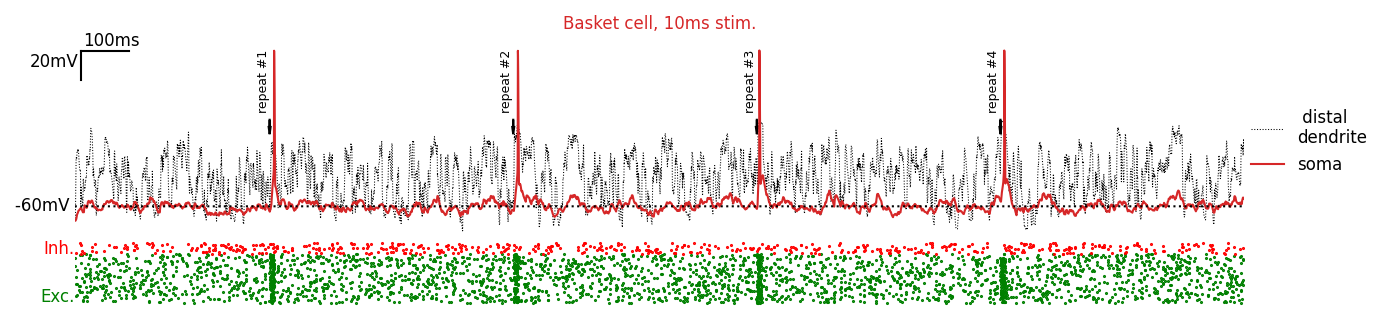

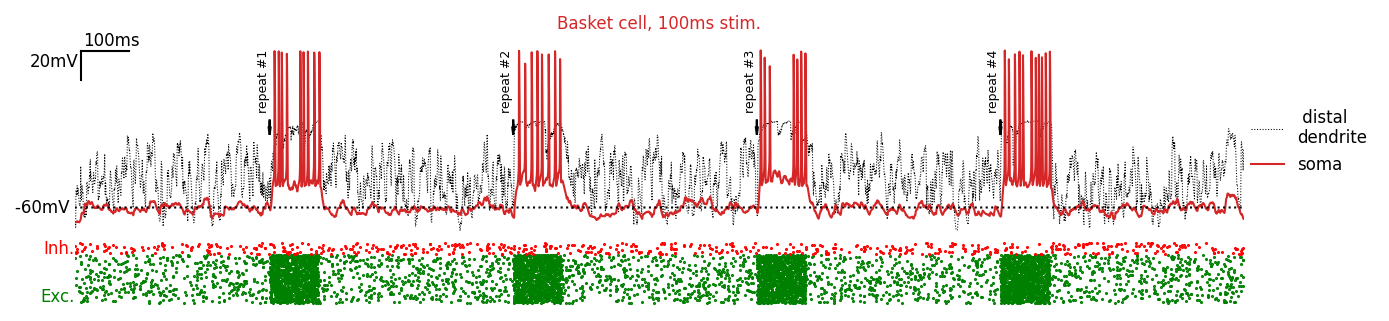

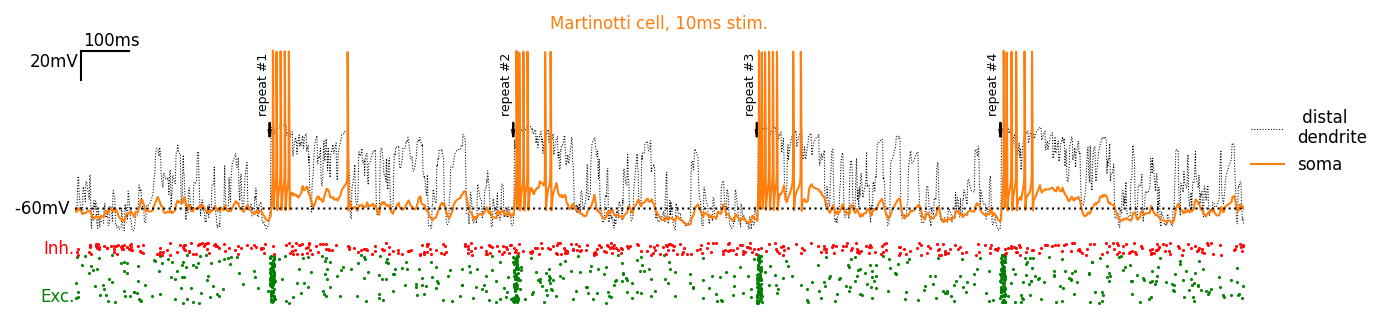

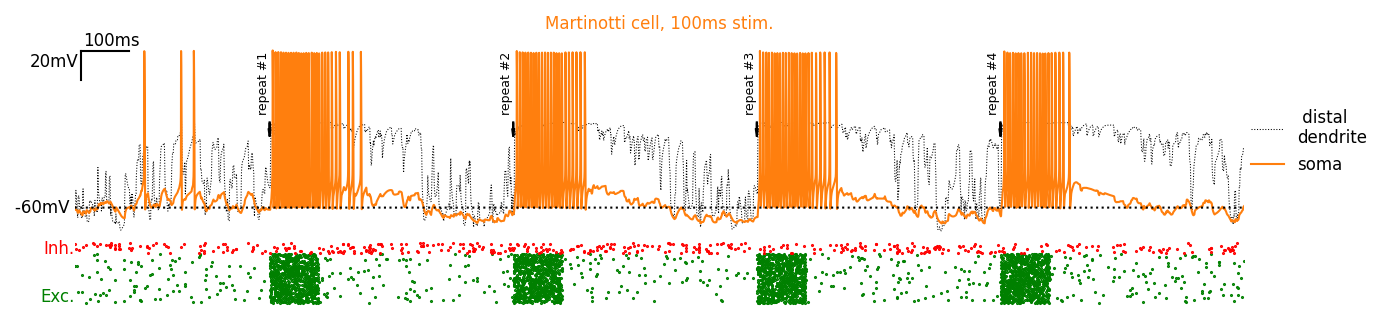

In [152]:
for cell, color in zip(['Basket', 'Martinotti'], ['tab:red', 'tab:orange']):
    for time in ['10ms', '100ms']:
        plot('../../data/detailed_model/IT-%s-%s.npy' % (cell, time),
             title='%s cell, %s stim.' % (cell, time), color=color)

### Functions to Load and Analyze the Simulation Data

In [83]:
def load_params_from(sim):
    p = {}
    for k in ['dt', 'nStimRepeat', 'ISI', 't0']:
        p[k] = sim.fetch_quantity_on_grid(k, dtype=float, return_last=True)
    return p

def show_Vm_trace(sim, 
                  loc='soma',
                  iBranch=0, freq=1e-2, width=5.,
                  varied_key = 'with_NMDA',
                  plot = {'with-NMDA':{'varied_key':True,
                                       'color':'tab:orange',
                                       'lw':1.0},
                          'without':{'varied_key':False,
                                    'color':'tab:grey',
                                    'lw':0.5}},
                  zoom=None):
    
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    
    params = dict(iBranch=iBranch, freq=freq, width=width)

    fig, ax = pt.figure(figsize=(2.5,2), left=0.2, bottom=0.5)

    Vms = {}
    for label in plot:
        params[varied_key] = plot[label]['varied_key']
        Vm = sim.get('Vm_%s' % loc, params)[0]
        t = np.arange(len(Vm))*p['dt']
        if zoom is not None:
            Vm = Vm[(t>zoom[0]) & (t<zoom[1])]
            t = t[(t>zoom[0]) & (t<zoom[1])]
        else:
            zoom=[t[0], t[-1]]
        ax.plot(t, Vm, label=label, color=plot[label]['color'], lw=plot[label]['lw'])

    for r in range(int(p['nStimRepeat'])):
        tstart = p['t0']+r*p['ISI']
        if (tstart>zoom[0]) and (tstart<zoom[1]):
            pt.arrow(ax, [tstart, 0, 0, -10],
                     head_width=4, head_length=5, width=0.1)
            pt.annotate(ax, 'f$_{syn}$=%i mHz/syn.' % (1e3*freq), (tstart, 5), 
                        rotation=90, xycoords='data', fontsize=6, ha='right')
            
    ax.axis('off')
    ax.legend(loc=(1,0.4), frameon=False)
    pt.draw_bar_scales(ax, Xbar=100, Xbar_label='100ms', Ybar=20, Ybar_label='20mV')
    return fig

def extract_trials(sim, 
                   varied_key = 'with_NMDA',
                   true_false_labels=['with-NMDA', 'without'],
                   loc='soma',
                   pre=-30, post=250):
    """
    returns elements of shape:
               VMs     (nBranch, nStims, nStimRepeat, nTimeSamples)
               SPIKES  (nBranch, nStims, nStimRepeat, nTimeSamples)
    """
    sim.fetch_quantity_on_grid('Vm_%s' % loc, dtype=object) 
    p = load_params_from(sim)
    sim.dt = np.unique(p['dt'])[0]
    
    sim.T = np.arange(int(pre/sim.dt), int(post/sim.dt))*sim.dt
    nBranch = len(np.unique(sim.iBranch))
    nFreq = len(np.unique(sim.freq))
    nWidth = len(np.unique(sim.width))
    sim.VMs, sim.SPIKEs, sim.RATEs = {}, {}, {}
    
    for l, label in enumerate(true_false_labels):
        
        sim.VMs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)))
        sim.SPIKEs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)), dtype=int)
        sim.RATEs[label] = np.zeros((nFreq, nWidth, nBranch, int(p['nStimRepeat']), len(sim.T)), dtype=float)
        
        for iFreq, freq in enumerate(np.unique(sim.freq)):
            for iWidth, width in enumerate(np.unique(sim.width)):
                for iBranch in np.unique(sim.iBranch):

                    params = {varied_key:(label==true_false_labels[0]),
                              'freq':freq, 'width':width, 'iBranch':iBranch}

                    Vm = sim.get('Vm_%s' % loc, params)[0]

                    _, sim.VMs[label][iFreq, iWidth, iBranch, :, :],\
                        sim.SPIKEs[label][iFreq, iWidth, iBranch, :, :] = \
                            trial_alignement(Vm, p, pre=pre, post=post)
                    sim.RATEs[label][iFreq, iWidth, iBranch, :, :] =\
                            1e3*sim.SPIKEs[label][iFreq, iWidth, iBranch, :, :]/sim.dt

        
def trial_alignement(Vm, p, 
                     spike_threshold=-20,
                     pre=-30, post=250):
    
    t = np.arange(len(Vm))*p['dt']
    T = np.arange(int(pre/p['dt']), int(post/p['dt']))*p['dt']
    VMs = np.zeros((int(p['nStimRepeat']), len(T)))
    SPIKEs = np.zeros((int(p['nStimRepeat']), len(T)), dtype=int)
    for r in range(int(p['nStimRepeat'])):
        tstart = p['t0']+r*p['ISI']
        cond = t>=(tstart+T[0])
        VMs[r,:] = Vm[cond][:len(T)]
        # count spikes
        iSpks =np.argwhere((VMs[r,:][1:]>=spike_threshold) & (VMs[r,:][:-1]<spike_threshold))
        SPIKEs[r,1:][iSpks] = 1
        
    return T, VMs, SPIKEs

# Martinotti cell

In [18]:
simM = Parallel(\
        filename='../../data/detailed_model/TimingStim_sim_Martinotti.zip')
simM.load()
extract_trials(simM)

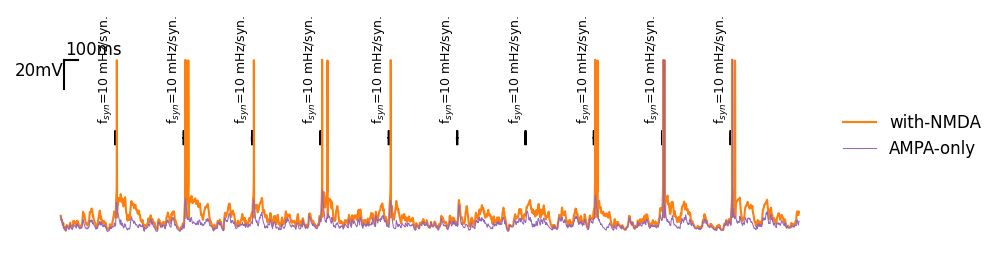

In [16]:
t0 = 0
fig = show_Vm_trace(simM, 
                    iBranch=2, width=10,
                    zoom=[t0,t0+8000],
              varied_key = 'with_NMDA',
              plot = {'with-NMDA':{'varied_key':True,
                                   'color':'tab:orange',
                                   'lw':1.0},
                      'AMPA-only':{'varied_key':False,
                                   'color':'tab:purple',
                                   'lw':0.5}})

Text(0.5, 1.0, 'n=6 branches')

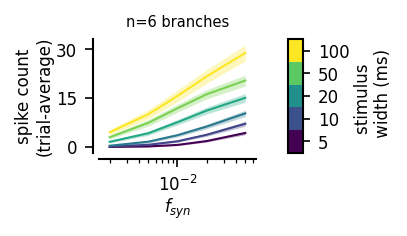

In [61]:
fig, ax = pt.figure(figsize=(1.1,1.2), right=10.)
ba = pt.inset(ax, [1.2,0,0.1,1])

cmap = plt.cm.viridis
pt.bar_legend(ax, ax_colorbar=ba, 
              X=np.arange(len(np.unique(sim.width))), 
              ticks=np.arange(len(np.unique(sim.width))), 
              ticks_labels=['%s'% w for w in np.unique(sim.width)],
              label='stimulus \n width (ms)',
              colormap=cmap)

label='with-NMDA'
x = np.unique(sim.freq)
for iWidth, width in enumerate(np.unique(sim.width)):
    spike_count = SPIKEs[label][:,iWidth,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.plot(x, np.mean(spike_count, axis=-1),
            sy=sem(spike_count, axis=-1),
            color=cmap(iWidth/(len(np.unique(sim.width))-1)), ax=ax)
            
pt.set_plot(ax, xlabel='$f_{syn}$', xscale='log',
            #yticks=[0,0.5,1],
            #xticks=[0, 20, 40], #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
ax.set_title('n=6 branches', fontsize=7)
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.eps')
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.svg')

# Basket Cell

In [91]:
simB = Parallel(\
        filename='../../data/detailed_model/TimingStim_sim_Basket.zip')
simB.load()
extract_trials(simB, varied_key = 'from_uniform', true_false_labels=['real', 'uniform'])

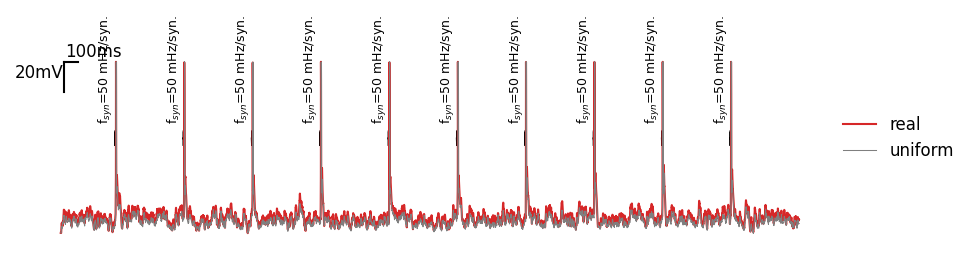

In [89]:
t0 = 0
fig = show_Vm_trace(simB, 
                    iBranch=2, width=10, freq=np.unique(sim.freq)[-1],
                    zoom=[t0,t0+8000],
              varied_key = 'from_uniform',
              plot = {'real':{'varied_key':False,
                                   'color':'tab:red',
                                   'lw':1.0},
                      'uniform':{'varied_key':True,
                                   'color':'tab:grey',
                                   'lw':0.5}})

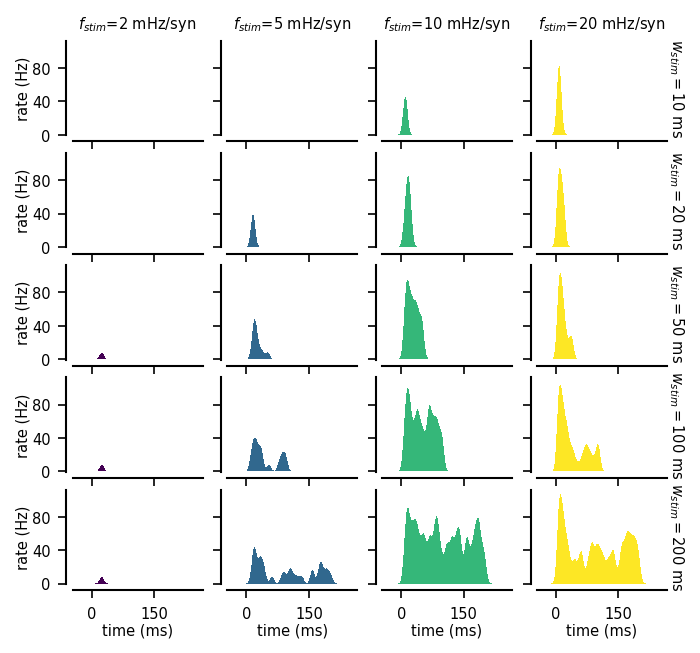

In [143]:
fig = psth_fig(simB, np.unique(simB.freq)[:-1], np.unique(simB.width)[1:],
               label='real',
               smoothing=5,
               iBranch=0)
fig.savefig('../../figures/detailed_model/intensity-timing-Basket-psth.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '1.svg'))

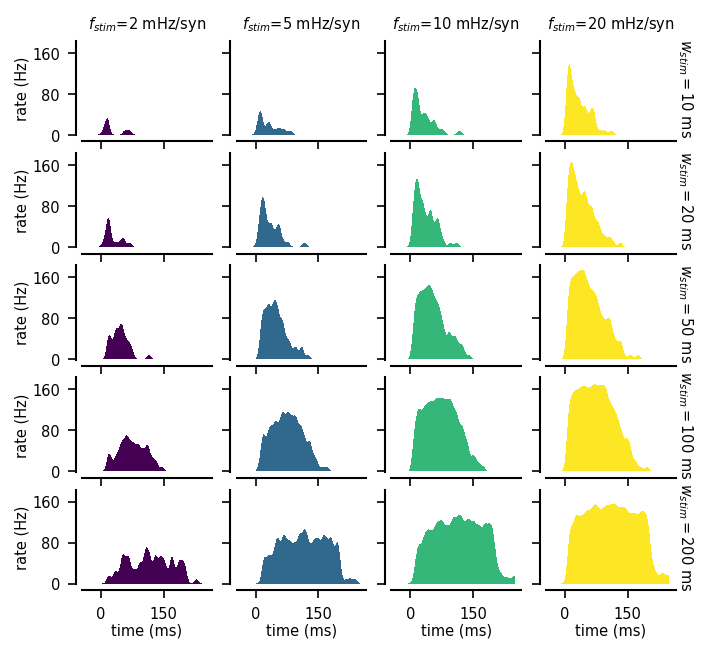

In [142]:
from scipy.ndimage import gaussian_filter1d

def psth_fig(sim, freqs, widths,
             label='real',
             smoothing=5, 
             iBranch = 0,
             cmap = pt.viridis):
    
    fig, AX = pt.figure(axes=(len(freqs), len(widths)),
                        figsize=(1,1), hspace=0.3, wspace=0.3)
    iSmooth = int(smoothing/sim.dt)
    iSbsmpl = 10 # int(iSmooth/2)
    
    for iX, freq in enumerate(freqs):
        iFreq = np.flatnonzero(np.unique(sim.freq)==freq)[0]
        for iY, width in enumerate(widths):
            iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
            AX[iY][iX].bar(T[::iSbsmpl], 
                           gaussian_filter1d(sim.RATEs[label][iFreq,iWidth,iBranch,:,:].mean(axis=0), iSmooth)[::iSbsmpl],
                           color=cmap(iX/(len(freqs)-1)))
            pt.set_plot(AX[iY][iX],
                        title='$f_{stim}$=%i mHz/syn' % (1e3*freq) if not iY else '',
                        xticks_labels=None if iY==(len(widths)-1)  else [],
                        xlabel='time (ms)' if iY==(len(widths)-1) else'',
                        ylabel='rate (Hz)' if iX==0 else'',
                        yticks_labels=None if iX==0 else [],
                        fontsize=7)
            if iX==(len(freqs)-1):
                pt.annotate(AX[iY][iX], '$w_{stim}=%i$ ms' % width, (1, 0.5), va='center', rotation=270, fontsize=7)
    
    pt.set_common_ylims(AX)
    pt.set_common_xlims(AX)
    return fig
    
fig = psth_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               iBranch=1,
               label='with-NMDA')
fig.savefig('../../figures/detailed_model/intensity-timing-Martinotti-psth.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '2.svg'))

Text(0.5, 1.0, 'n=6 branches')

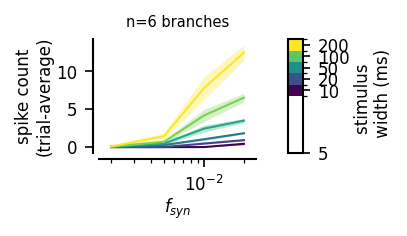

In [41]:
fig, ax = pt.figure(figsize=(1.1,1.2), right=10.)
ba = pt.inset(ax, [1.2,0,0.1,1])

cmap = plt.cm.viridis
pt.bar_legend(ax, ax_colorbar=ba, 
              X=np.arange(len(np.unique(sim.width))), 
              ticks=np.arange(len(np.unique(sim.width))), 
              ticks_labels=['%s'% w for w in np.unique(sim.width)],
              label='stimulus \n width (ms)',
              colormap=cmap)

label='real'
x = np.unique(sim.freq)
for iWidth, width in enumerate(np.unique(sim.width)):
    spike_count = SPIKEs[label][:,iWidth,:,:,:].sum(axis=-1).mean(axis=-1) # time, then trials
    pt.plot(x[:-1], np.mean(spike_count, axis=-1)[:-1],
            sy=sem(spike_count, axis=-1)[:-1],
            color=cmap(iWidth/(len(np.unique(sim.width))-1)), ax=ax)
            
pt.set_plot(ax, xlabel='$f_{syn}$', xscale='log',
            #yticks=[0,0.5,1],
            #xticks=[0, 20, 40], #xticks_labels=['5', '', '25', '', '45'],
            ylabel='spike count\n(trial-average)')
ax.set_title('n=6 branches', fontsize=7)
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.eps')
#fig.savefig('../../figures/detailed_model/spiking-responses-Basket.svg')

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf


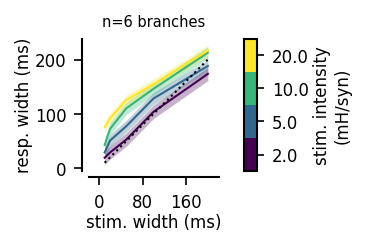

In [155]:
from scipy.stats import sem

def width_fig(sim, freqs, widths,
              label='real',
              iBranch = 0,
              smoothing=5,
              threshold=10,
              cmap = pt.viridis):
    
    # analysis
    nBranch = len(np.unique(sim.iBranch))
    respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
    for iX, freq in enumerate(freqs):
        iFreq = np.flatnonzero(np.unique(sim.freq)==freq)[0]
        for iY, width in enumerate(widths):
            iWidth = np.flatnonzero(np.unique(sim.width)==width)[0]
            for _, iBranch in enumerate(np.unique(sim.iBranch)):
                rate = gaussian_filter1d(\
                                sim.RATEs[label][iFreq,iWidth,iBranch,:,:].mean(axis=0),# trials
                                int(smoothing/sim.dt))
                up = (sim.T>0) & (rate>threshold) # rate more than threshold
                if np.sum(up)>0:
                    respWidths[iX,iY,iBranch] = sim.T[up][-1]-sim.T[up][0] # first and 

    # plot
    fig, ax = pt.figure(figsize=(1.,1.4), right=10.)
    for iX, freq in enumerate(freqs):
        rW = respWidths[iX,:,:]
        pt.plot(widths, np.nanmean(rW, axis=-1),
                sy=sem(rW[np.isfinite(rW)], axis=-1),
                color=cmap(iX/(len(freqs)-1)), ax=ax, no_set=True)
    ax.plot(widths, widths, 'k:', lw=1)#, alpha=.5)
    # bar legend
        
    ba = pt.inset(ax, [1.2,0,0.1,1])
    pt.bar_legend(ax, ax_colorbar=ba, 
                      X=np.arange(len(freqs)), 
                      ticks=np.arange(len(freqs)), 
                      ticks_labels=['%s'% (1e3*w) for w in np.unique(freqs)],
                      label='stim. intensity\n(mH/syn)',
                      colormap=cmap)

    ax.axis('equal')
    pt.set_plot(ax, 
                xlim=[0, widths[-1]],
                xlabel='stim. width (ms)',
                ylabel='resp. width (ms)')
    ax.set_title('n=6 branches', fontsize=7)

    return fig

fig = width_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               label='with-NMDA')


fig.savefig('../../figures/detailed_model/intensity-timing-Martinotti-width.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '4.svg'))

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/879535251.py:29: RuntimeWarning: Mean of empty slice
  pt.plot(widths, np.nanmean(rW, axis=-1),
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


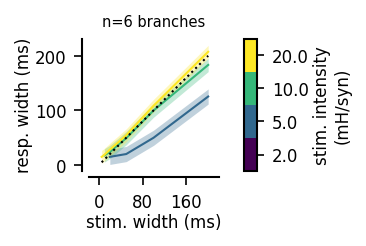

In [154]:
fig = width_fig(simB, np.unique(simM.freq)[:-1], np.unique(simM.width),
               label='real')
fig.savefig('../../figures/detailed_model/intensity-timing-Basket-width.svg')
fig.savefig(os.path.join(os.path.expanduser('~'), 'Desktop', '3.svg'))

/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/1924566592.py:12: RuntimeWarning: invalid value encountered in multiply
  respWidths = np.zeros((len(freqs), len(widths), nBranch))*np.inf
/var/folders/c4/mwyxnzxd5sbg13wbvl14pdjc0000gp/T/ipykernel_3040/1924566592.py:29: RuntimeWarning: Mean of empty slice
  pt.plot(widths, np.nanmean(rW, axis=-1),
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/yann/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


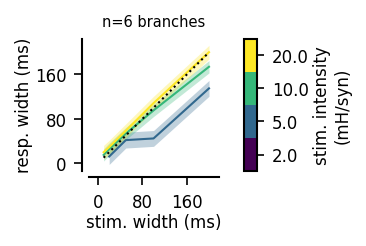

In [135]:
fig = width_fig(simM, np.unique(simM.freq)[:-1], np.unique(simM.width)[1:],
               label='without')